In [2]:
%matplotlib inline
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac, unweighted_unifrac_fast, weighted_unifrac_fast
import pandas as pd
from qiime_default_reference import get_reference_tree
from skbio import TreeNode
from skbio.diversity._fast_base import index_tree
from biom import load_table
from skbio.diversity.beta._fast_unifrac import make_pdist, unifrac, w_unifrac
from cogent.maths.unifrac.fast_tree import UniFracTreeNode
from cogent.maths.unifrac.fast_unifrac import fast_unifrac
from cogent.parse.tree import DndParser
from skbio.diversity.beta import pw_distances
import numpy as np


np.random.seed(1234)

bench_data = load_table('data/AG_even10k.biom')
tree = TreeNode.read(get_reference_tree())

# correct a missing branchlength in the reference tree
for n in tree.traverse(include_self=False):
    if n.length is None:
        n.length = 0.0
        
def make_and_run_pw_distances(method, counts, otu_ids, tree, normalized=False, ids=None):
    metric, counts_array, length = make_pdist(counts, otu_ids, tree, normalized=normalized, metric=method)
    return pw_distances(metric, counts_array, ids=ids)

def get_random_samples(n, tree, shear):
    samples = bench_data.subsample(n, by_id=True)
    samples.filter(lambda v, i, md: v.sum() > 0, axis='observation')  # remove zero'd observations in place
    ids = samples.ids().copy()
    otu_ids = samples.ids(axis='observation').copy()
    otu_data = samples.matrix_data.toarray().T
    if shear:
        t = tree.shear(otu_ids)
    else:
        t = tree.copy()
        
    return ids, otu_ids, otu_data, t

In [3]:
pyco_tree = DndParser(str(tree), UniFracTreeNode)

Verify producing the sames results.

In [4]:
def qiime_unifrac_distance_matrix(table, sample_ids, otu_ids, tree, weighted=False):
    """
    Parameters
    ----------
    table : np.array
       Contingency table
       samples = rows
       observations = columns
    sample_ids : list, str
       List of sample ids
    otu_ids : list, str
       List of otu ids
    tree : pycogent.tree
       phylogenetic tree data structure

    Returns
    -------
    np.array :
       Unifrac distance matrix
    """
    df = pd.DataFrame(table, index=sample_ids, columns=otu_ids)
    env = df.to_dict()
    res = fast_unifrac(tree, env, weighted=weighted)
    dist_mat = pd.DataFrame(res['distance_matrix'][0],
                            index=res['distance_matrix'][1],
                            columns=res['distance_matrix'][1])
    return dist_mat


In [5]:
import numpy.testing as npt
np.random.seed(0)
ids, otu_ids, otu_data, t = get_random_samples(10, tree, True)

fu_mat = make_and_run_pw_distances(unifrac, otu_data, otu_ids=otu_ids, tree=t)
u_mat = pw_distances(unweighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
fwu_mat = make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t)
wu_mat = pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
fwun_mat = make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
wun_mat = pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
qiime_fwu_mat = qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=True)
qiime_fu_mat = qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=False)
npt.assert_almost_equal(fu_mat.data, u_mat.data)
npt.assert_almost_equal(fwu_mat.data, wu_mat.data)
npt.assert_almost_equal(fwun_mat.data, wun_mat.data)

fu_df = pd.DataFrame(fu_mat.data, index=ids, columns=ids).sort_index(axis=0).sort_index(axis=1)
fwu_df = pd.DataFrame(fwu_mat.data, index=ids, columns=ids).sort_index(axis=0).sort_index(axis=1)
qiime_fu_df = qiime_fu_mat.sort_index(axis=0).sort_index(axis=1)
qiime_fwu_df = qiime_fwu_mat.sort_index(axis=0).sort_index(axis=1)

npt.assert_almost_equal(fu_df.values, qiime_fu_df.values)
npt.assert_almost_equal(fwu_df.values, qiime_fwu_df.values)

General timing

In [6]:
%timeit make_and_run_pw_distances(unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit pw_distances(unweighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
%timeit pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
%timeit qiime_fwu_mat = qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=True)
%timeit qiime_fu_mat = qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=False)

10 loops, best of 3: 23 ms per loop
1 loops, best of 3: 1.01 s per loop
10 loops, best of 3: 22.4 ms per loop
1 loops, best of 3: 1.16 s per loop
10 loops, best of 3: 101 ms per loop
1 loops, best of 3: 1.46 s per loop
1 loops, best of 3: 3.63 s per loop
1 loops, best of 3: 3.61 s per loop


API testing, making the same method calls and verifying results. Intentionally doing the full matrix in the (very unexpected event) that d(u, v) != d(v, u)

In [7]:
method_sets = [[unweighted_unifrac, unweighted_unifrac_fast], 
               [weighted_unifrac, weighted_unifrac_fast]]

ids, otu_ids, otu_data, t = get_random_samples(5, tree, True)

for i in range(len(otu_data)):
    for j in range(len(otu_data)):
        for method_set in method_sets:
            method_results = []
            for method in method_set:
                method_results.append(method(otu_data[i], otu_data[j], otu_ids, t))
            npt.assert_almost_equal(*method_results)

`pw_distances` scaling tests.

In [8]:
sample_counts = [2, 4, 8, 16, 32]

uw_times = []
uwf_times = []
quwf_times = []
w_times = []
wn_times = []
wf_times = []
qwf_times = []
wnf_times = []
uw_times_p = []
uwf_times_p = []
quwf_times_p = []
w_times_p = []
wn_times_p = []
wf_times_p = []
qwf_times_p = []
wnf_times_p = []

for n_samples in sample_counts:
    ids, otu_ids, otu_data, t = get_random_samples(n_samples, tree, True)

    # sheared trees
    for times, method in [[uw_times_p, unweighted_unifrac], [w_times_p, weighted_unifrac]]:
        result = %timeit -o pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)

    result = %timeit -o pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
    wn_times_p.append(result.best)
        
    
    for times, method in [[uwf_times_p, unifrac], [wf_times_p, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
    wnf_times_p.append(result.best)     

    result = %timeit -o qiime_fwu_mat = qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=False)
    quwf_times_p.append(result.best)    
    
    result = %timeit -o qiime_fwu_mat = qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=True)
    qwf_times_p.append(result.best)


    
    # full trees
    for times, method in [[uw_times, unweighted_unifrac], [w_times, weighted_unifrac]]:
        result = %timeit -o pw_distances(method, otu_data, otu_ids=otu_ids, tree=tree)
        times.append(result.best)

    result = %timeit -o pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=tree, normalized=True)
    wn_times.append(result.best)    
        
    for times, method in [[uwf_times, unifrac], [wf_times, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=tree)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=tree, normalized=True)
    wnf_times.append(result.best)     
    
    result = %timeit -o qiime_fwu_mat = qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=False)
    quwf_times.append(result.best)
    
    result = %timeit -o qiime_fwu_mat = qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=True)
    qwf_times.append(result.best)

100 loops, best of 3: 12.8 ms per loop
100 loops, best of 3: 15 ms per loop
10 loops, best of 3: 18.6 ms per loop
100 loops, best of 3: 5.62 ms per loop
100 loops, best of 3: 6.35 ms per loop
100 loops, best of 3: 7.65 ms per loop
1 loops, best of 3: 3.93 s per loop
1 loops, best of 3: 3.65 s per loop
1 loops, best of 3: 309 ms per loop
1 loops, best of 3: 314 ms per loop
1 loops, best of 3: 334 ms per loop
1 loops, best of 3: 1.25 s per loop
1 loops, best of 3: 1.36 s per loop
1 loops, best of 3: 1.5 s per loop
1 loops, best of 3: 3.72 s per loop
1 loops, best of 3: 3.84 s per loop
10 loops, best of 3: 83.9 ms per loop
10 loops, best of 3: 93.2 ms per loop
10 loops, best of 3: 125 ms per loop
100 loops, best of 3: 10 ms per loop
100 loops, best of 3: 10.5 ms per loop
100 loops, best of 3: 16.3 ms per loop
1 loops, best of 3: 3.56 s per loop
1 loops, best of 3: 3.54 s per loop
1 loops, best of 3: 1.81 s per loop
1 loops, best of 3: 1.86 s per loop
1 loops, best of 3: 1.94 s per loop
1 

u	: unweighted unifrac
w	: weighted unifrac
fu	: unweighted fast unifrac
fw	: weighted fast unifrac
wn	: weighted normalized unifrac
fwn	: weighted normalized fast unifrac
quwf	: pycogent unweighted fast unifrac
qwf	: pycogent weighted fast unifrac
u-p	: unweighted unifrac pruned tree
w-p	: weighted unifrac pruned tree
fu-p	: unweighted fast unifrac pruned tree
fw-p	: weighted fast unifrac pruned tree
wn-p	: weighted normalized unifrac pruned tree
fwn-p	: weighted normalized fast unifrac pruned tree
quwf-p	: pycogent unweighted fast unifrac pruned tree
qwf-p	: pycogent weighted fast unifrac pruned tree


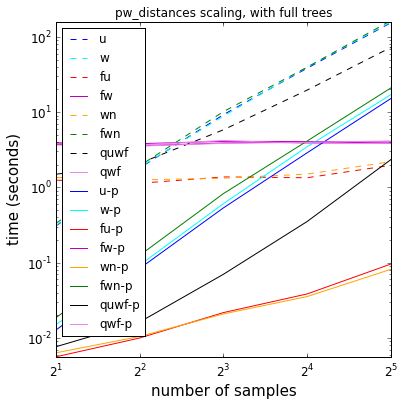

In [13]:
from matplotlib.pyplot import *
fig = figure(figsize=(6,6))
plot(sample_counts, uw_times, '--', color='blue')
plot(sample_counts, w_times, '--', color='cyan')
plot(sample_counts, uwf_times, '--', color='red')
plot(sample_counts, quwf_times, color='m')
plot(sample_counts, wf_times, '--', color='orange')
plot(sample_counts, wn_times, '--', color='green')
plot(sample_counts, wnf_times, '--', color='black')
plot(sample_counts, qwf_times, color='violet')

plot(sample_counts, uw_times_p, color='blue')
plot(sample_counts, w_times_p, color='cyan')
plot(sample_counts, uwf_times_p, color='red')
plot(sample_counts, quwf_times_p, color='m')
plot(sample_counts, wf_times_p, color='orange')
plot(sample_counts, wn_times_p, color='green')
plot(sample_counts, wnf_times_p, color='black')
plot(sample_counts, qwf_times_p, color='violet')

legend_acronyms = [
    ('u', 'unweighted unifrac'), 
    ('w', 'weighted unifrac'), 
    ('fu', 'unweighted fast unifrac'), 
    ('fw', 'weighted fast unifrac'), 
    ('wn', 'weighted normalized unifrac'), 
    ('fwn', 'weighted normalized fast unifrac'), 
    ('quwf', 'pycogent unweighted fast unifrac'),
    ('qwf', 'pycogent weighted fast unifrac'),
    ('u-p', 'unweighted unifrac pruned tree'), 
    ('w-p', 'weighted unifrac pruned tree'), 
    ('fu-p', 'unweighted fast unifrac pruned tree'), 
    ('fw-p', 'weighted fast unifrac pruned tree'), 
    ('wn-p', 'weighted normalized unifrac pruned tree'), 
    ('fwn-p', 'weighted normalized fast unifrac pruned tree'),
    ('quwf-p', 'pycogent unweighted fast unifrac pruned tree'),
    ('qwf-p', 'pycogent weighted fast unifrac pruned tree')
]

legend([i[0] for i in legend_acronyms], loc=2)
title("pw_distances scaling, with full trees")
xlabel('number of samples', fontsize=15)
ylabel('time (seconds)', fontsize=15)
xscale('log', basex=2)
yscale('log')
xlim(min(sample_counts), max(sample_counts))
ylim(min(uwf_times_p), max(w_times))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
savefig('edu vs fast.png')

for ac, name in legend_acronyms:
    print("%s\t: %s" % (ac, name))

Extend to larger sample counts for fast unifrac

In [ ]:
sample_counts_ext = [64, 128, 256, 512, 1024]
for n_samples in sample_counts_ext:
    print("sample count: %d" % n_samples)
    ids, otu_ids, otu_data, t = get_random_samples(n_samples, tree, True)

    for times, method in [[uwf_times_p, unifrac], [wf_times_p, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
    wnf_times_p.append(result.best)     
    
    result = %timeit -o qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=False)
    quwf_times_p.append(result.best)     
    
    result = %timeit -o qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=True)
    qwf_times_p.append(result.best)     
    
    for times, method in [[uwf_times, unifrac], [wf_times, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=tree)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=tree, normalized=True)
    wnf_times.append(result.best) 
    
    result = %timeit -o qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=False)
    quwf_times.append(result.best)     
    
    result = %timeit -o qiime_unifrac_distance_matrix(otu_data, sample_ids=ids, otu_ids=otu_ids, tree=pyco_tree, weighted=True)
    qwf_times.append(result.best)     


sample count: 64
1 loops, best of 3: 351 ms per loop
1 loops, best of 3: 242 ms per loop
1 loops, best of 3: 14.9 s per loop
1 loops, best of 3: 4.37 s per loop

In [ ]:
# at 4GB mem for 1024 set, counts array in this case is ~(1024 x 180000) or approx 1.4GB
# so not _that_ bad given the other resident data structures and notebook state.

sample_counts_ext = [64, 128, 256, 512, 1024]

sample_counts_full = sample_counts[:]
sample_counts_full.extend(sample_counts_ext)
                                  
fig = figure(figsize=(6,6))
plot(sample_counts_full, uwf_times, '--', color='red')
plot(sample_counts_full, wf_times, '--', color='orange')
plot(sample_counts_full, quwf_times, '--', color='green')
plot(sample_counts_full, qwf_times, '--', color='blue')
plot(sample_counts_full, wnf_times, '--', color='black')
plot(sample_counts_full, uwf_times_p, color='red')
plot(sample_counts_full, wf_times_p, color='orange')
plot(sample_counts_full, quwf_times_p, color='green')
plot(sample_counts_full, qwf_times_p, color='blue')
plot(sample_counts_full, wnf_times_p, color='black')

legend_acronyms = [
    ('fu', 'unweighted fast unifrac'), 
    ('fw', 'weighted fast unifrac'), 
    ('qfu', 'pycogent unweighted fast unifrac'), 
    ('qfw', 'pycogent weighted fast unifrac'), 
    ('fwn', 'weighted normalized fast unifrac'), 
    ('fu-p', 'unweighted fast unifrac pruned tree'), 
    ('fw-p', 'weighted fast unifrac pruned tree'), 
    ('qfu-p', 'pycogent unweighted fast unifrac pruned tree'), 
    ('qfw-p', 'pycogent weighted fast unifrac pruned tree'), 
    ('fwn-p', 'weighted normalized fast unifrac pruned tree')
]

legend([i[0] for i in legend_acronyms], loc=2)
title("pw_distances scaling, extended fast unifrac")
xlabel('number of samples', fontsize=15)
ylabel('time (seconds)', fontsize=15)
xscale('log', basex=2)
yscale('log')
xlim(min(sample_counts_full), max(sample_counts_full))
ylim(min(uwf_times_p), max([uwf_times[-1], wf_times[-1], wnf_times[-1]]))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
savefig('fast extended.png')

for ac, name in legend_acronyms:
    print("%s\t: %s" % (ac, name))

In [ ]:
n_upper_tri = lambda n: max((n**2 / 2.0) - n, 1)
time_per_calc = lambda times, counts: [(t / n_upper_tri(c)) for t, c in zip(times, counts)]

fig = figure(figsize=(6,6))
plot(sample_counts_full, time_per_calc(uwf_times, sample_counts_full), '--', color='red')
plot(sample_counts_full, time_per_calc(wf_times, sample_counts_full), '--', color='orange')
plot(sample_counts_full, time_per_calc(quwf_times, sample_counts_full), '--', color='red')
plot(sample_counts_full, time_per_calc(qwf_times, sample_counts_full), '--', color='orange')
plot(sample_counts_full, time_per_calc(wnf_times, sample_counts_full), '--', color='black')
plot(sample_counts_full, time_per_calc(uwf_times_p, sample_counts_full), color='red')
plot(sample_counts_full, time_per_calc(wf_times_p, sample_counts_full), color='orange')
plot(sample_counts_full, time_per_calc(quwf_times_p, sample_counts_full), color='red')
plot(sample_counts_full, time_per_calc(qwf_times_p, sample_counts_full), color='orange')
plot(sample_counts_full, time_per_calc(wnf_times_p, sample_counts_full), color='black')

legend_acronyms = [
    ('fu', 'unweighted fast unifrac'), 
    ('fw', 'weighted fast unifrac'), 
    ('fwn', 'weighted normalized fast unifrac'), 
    ('fu-p', 'unweighted fast unifrac pruned tree'), 
    ('fw-p', 'weighted fast unifrac pruned tree'), 
    ('fwn-p', 'weighted normalized fast unifrac pruned tree')
]

legend([i[0] for i in legend_acronyms], loc=2)
title("pw_distances scaling, fast unifrac extended")
xlabel('number of samples', fontsize=15)
ylabel('time (seconds) per pairwise calc', fontsize=15)
xscale('log', basex=2)
yscale('log')
xlim(min(sample_counts_full), max(sample_counts_full))
#ylim(min(uwf_times_p), max([uwf_times[-1], wf_times[-1], wnf_times[-1]]))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
savefig('fast extended per calc.png')

for ac, name in legend_acronyms:
    print("%s\t: %s" % (ac, name))